# Import necessary libraries

In [6]:
# For Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# For Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# For Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix

from catboost import CatBoostClassifier

# For Warnings (to avoid warnings in output)
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [8]:
df = pd.read_csv("twitter_human_bots_dataset.csv")

In [9]:
df

,sn,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,profile_image_path,profile_background_image_path,split
0,0,2009-07-04 22:41:51,False,False,NaN,5007,102,168,False,53779179,...,https://pbs.twimg.com/profile_images/128969130...,paty_castroo,3974,False,0.978,4063,bot,NaN,NaN,0
1,1,2010-01-17 22:54:19,False,False,Television producer. Emmy Award winner. Disney...,1038,60,128,False,105916557,...,https://pbs.twimg.com/profile_images/632916759...,CBirckner,259,False,0.067,3866,human,profile_images/4691ae58668d932bb7e7af22141aecf...,profile_images/4691ae58668d932bb7e7af22141aecf...,0
2,2,2012-03-01 06:05:32,False,False,NaN,2257,599,449,True,509788597,...,https://pbs.twimg.com/profile_images/128853844...,amf_jay,13627,False,4.406,3093,human,NaN,NaN,0
3,3,2009-09-01 04:52:30,False,False,NaN,6407,116,334,True,70601327,...,https://pbs.twimg.com/profile_images/977012905...,SaraCavolo,4432,False,1.107,4005,human,profile_images/d1da9220e4aa376dff03b6f12765171...,profile_images/d1da9220e4aa376dff03b6f12765171...,0
4,4,2010-01-27 17:17:23,False,False,Productor de Televisión - Embajador de @Tienda...,20866,74448,18,True,108999927,...,https://pbs.twimg.com/profile_images/668449819...,DavidHenaoModel,15870,True,4.116,3856,human,profile_images/c65bf625b066ef5f29e14cfcf1ee91f...,profile_images/c65bf625b066ef5f29e14cfcf1ee91f...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,37433,2010-12-07 08:11:16,False,False,"Self Made Plus Model, #BeautyIsNotASize, CEO @...",59660,257294,196,True,223764929,...,https://pbs.twimg.com/profile_images/712018970...,AshAlexiss,58680,True,16.562,3543,human,profile_images/a2821682b21168555a2ec5e28a3ac81...,profile_images/a2821682b21168555a2ec5e28a3ac81...,2
37434,37434,2010-12-04 13:17:22,False,False,Gazeteci/Journalist ...,0,74666,95,False,222789645,...,https://pbs.twimg.com/profile_images/127353595...,ahmemis,41240,True,11.633,3545,human,NaN,NaN,2
37435,37435,2009-10-06 23:53:30,False,False,Modelo y Actriz Venezolana/ Venezuelan Model &...,28,255941,236,True,80438218,...,https://pbs.twimg.com/profile_images/114651544...,Yuvannamontalvo,6692,False,1.686,3969,human,NaN,NaN,2
37436,37436,2013-03-24 21:04:16,True,False,Indian!...Actor!...Need no more!,621,2678042,51,False,1296642259,...,https://pbs.twimg.com/profile_images/129570440...,IAmVarunTej,2042,True,0.755,2704,human,NaN,NaN,2


# Data preprocessing

### Check for missing rows

In [15]:
print(df.shape)

(37438, 23)


In [17]:
print(df.isnull().sum())

sn                                   0
created_at                           0
default_profile                      0
default_profile_image                0
description                       7257
favourites_count                     0
followers_count                      0
friends_count                        0
geo_enabled                          0
id                                   0
lang                              7957
location                             4
profile_background_image_url      4499
profile_image_url                    1
screen_name                          0
statuses_count                       0
verified                             0
average_tweets_per_day               0
account_age_days                     0
account_type                         0
profile_image_path               12938
profile_background_image_path    12938
split                                0
dtype: int64


### Filling missing values

In [20]:
df['description'].fillna('unknown', inplace=True)
df['lang'].fillna('unknown', inplace=True)

df['location'].fillna('unknown', inplace=True)

df.drop(['profile_image_path', 'profile_background_image_path'], axis=1, inplace=True)

df.dropna(subset=['profile_background_image_url', 'profile_image_url'], inplace=True)

### Encoding categorical features

In [23]:
df['account_type'] = df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)

In [25]:
df['geo_enabled'] = df['geo_enabled'].astype(int)
df['verified'] = df['verified'].astype(int)

In [27]:
df['default_profile'] = df['default_profile'].astype(int)
df['default_profile_image'] = df['default_profile_image'].astype(int)

### Change "created_at" column to more relevant columns

In [30]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['year_created'] = df['created_at'].dt.year
df['month_created'] = df['created_at'].dt.month
df['day_created'] = df['created_at'].dt.day
df = df.drop(columns=['created_at'])

### Dropping irrelevant columns

In [33]:
columns_to_drop = ['sn', 'id', 'screen_name','profile_background_image_url', 'profile_image_url']
df.drop(columns=columns_to_drop, inplace=True)

# Feature Engineering

### Add new feature columns

In [37]:
# Adding Interesting features 
df['avg_daily_followers'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_friends'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_favorites'] = np.round((df['followers_count'] / df['account_age_days']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

### Transforming Text Data with TF-IDF Vectorization

In [207]:
tfidf = TfidfVectorizer(max_features=500) 
description_tfidf = tfidf.fit_transform(df['description']).toarray()
tfidf_df = pd.DataFrame(description_tfidf, columns=tfidf.get_feature_names_out())
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
df.drop('description', axis=1, inplace=True)

### Create a separate copy of dataset for CatBoost model

In [210]:
df_catboost = df.copy()

### Encode Categorical Column but only for dataset for baseline models

In [213]:
label_encoder = LabelEncoder()
df['lang'] = label_encoder.fit_transform(df['lang'])

### Frequent Locations: Keep only the top N most frequent locations and replace the rest with 'other'.

In [215]:
top_locations = df['location'].value_counts().index[:10]
df['location'] = df['location'].apply(lambda x: x if x in top_locations else 'other')
df['location'] = label_encoder.fit_transform(df['location'])

# Data Visualization

### Correlation matrix of feature column

In [219]:
# Calculate the correlation matrix
correlation_columns = [
    'favourites_count', 'followers_count', 'friends_count', 'statuses_count', 
    'average_tweets_per_day', 'account_age_days', 'account_type', 'geo_enabled', 
    'verified', 'default_profile', 'default_profile_image', 'avg_daily_followers', 
    'avg_daily_friends', 'avg_daily_favorites', 'friends_log', 'followers_log', 
    'favs_log', 'avg_daily_tweets_log', 'network', 'tweet_to_followers', 
    'follower_acq_rate', 'friends_acq_rate', 'favs_rate', 'year_created', 
    'month_created', 'day_created', 'location', 'lang'
]
df_filtered = df[correlation_columns]
correlation_matrix = df_filtered.corr()

# Get the correlation with 'account_type' and sort it
correlation_with_account_type = correlation_matrix[['account_type']].sort_values(by='account_type', ascending=False)

# Display the correlation with 'account_type'
print("Correlation of 'account_type':")
print(correlation_with_account_type)

Correlation of 'account_type':
                        account_type
account_type                1.000000
default_profile             0.289627
lang                        0.265623
year_created                0.194623
location                    0.169187
default_profile_image       0.097398
month_created               0.049030
average_tweets_per_day      0.016768
friends_count               0.011394
statuses_count              0.000831
day_created                -0.010193
followers_count            -0.084816
friends_acq_rate           -0.087417
favs_rate                  -0.087417
avg_daily_followers        -0.093115
avg_daily_friends          -0.093115
avg_daily_favorites        -0.093115
favourites_count           -0.157729
account_age_days           -0.199394
avg_daily_tweets_log       -0.205983
favs_log                   -0.273814
follower_acq_rate          -0.298356
verified                   -0.316591
geo_enabled                -0.330039
tweet_to_followers         -0.431632
network

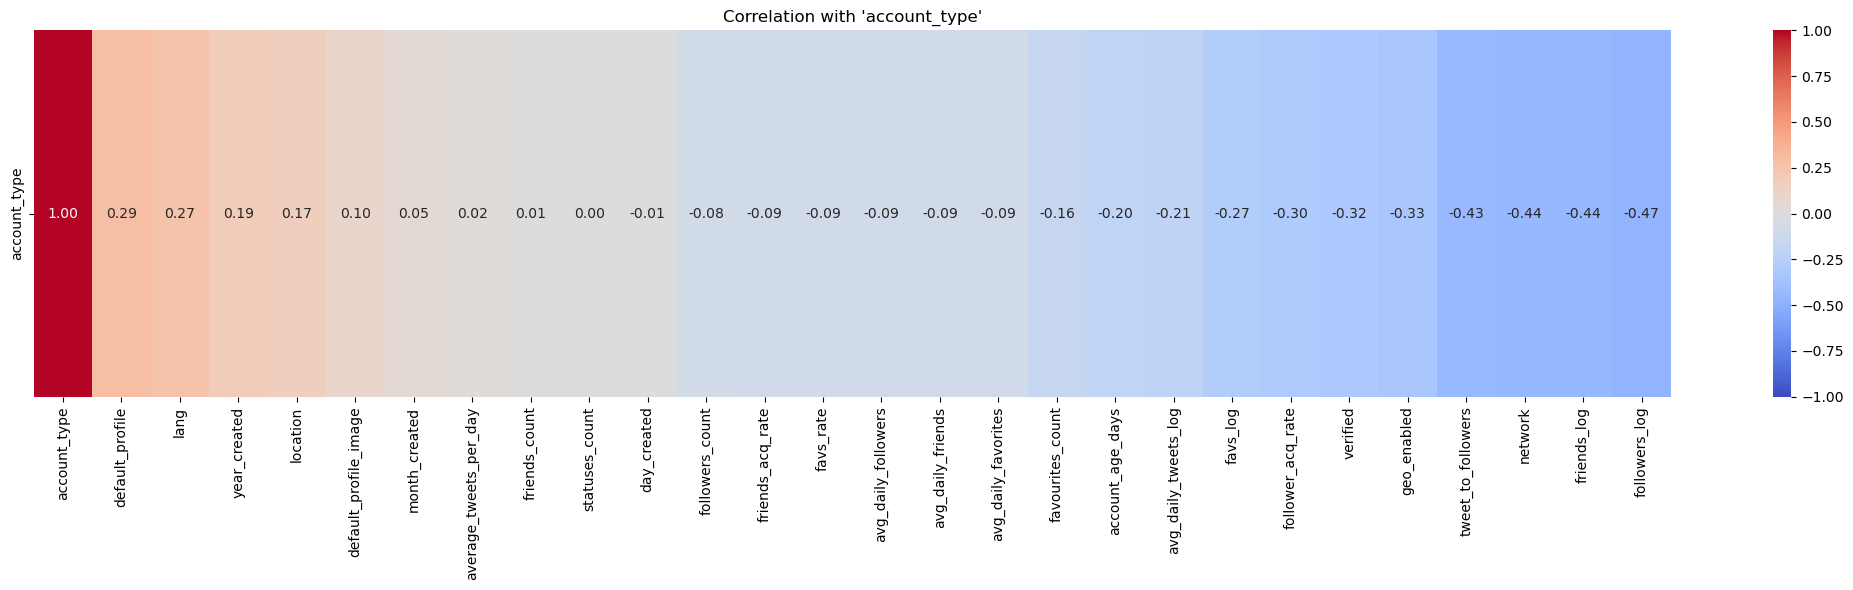

In [225]:
print()
plt.figure(figsize=(21, 6))
sns.heatmap(correlation_with_account_type.T, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation with 'account_type'")
plt.tight_layout()
plt.show()

### Target column data visualization

In [228]:
num_bots = len(df[df['account_type'] == 1])
num_humans = len(df[df['account_type'] == 0])

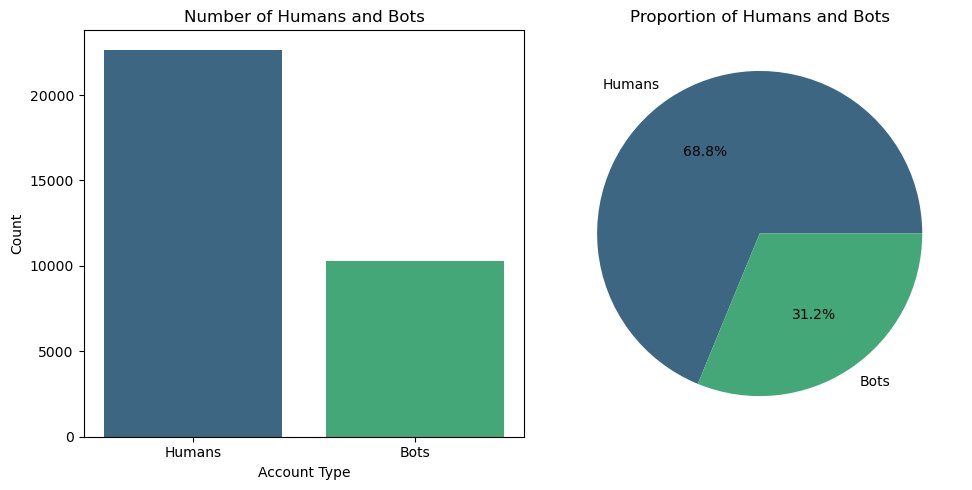

In [230]:
categories = ['Humans', 'Bots']
counts = [num_humans, num_bots]

print()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Bar Chart
axes[0].bar(categories, counts, color=['#3c6682', '#44a778'])
axes[0].set_title('Number of Humans and Bots')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Account Type')

# Pie Chart
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', colors=['#3c6682', '#44a778'])
axes[1].set_title('Proportion of Humans and Bots')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Data visualization of target label with refeatures

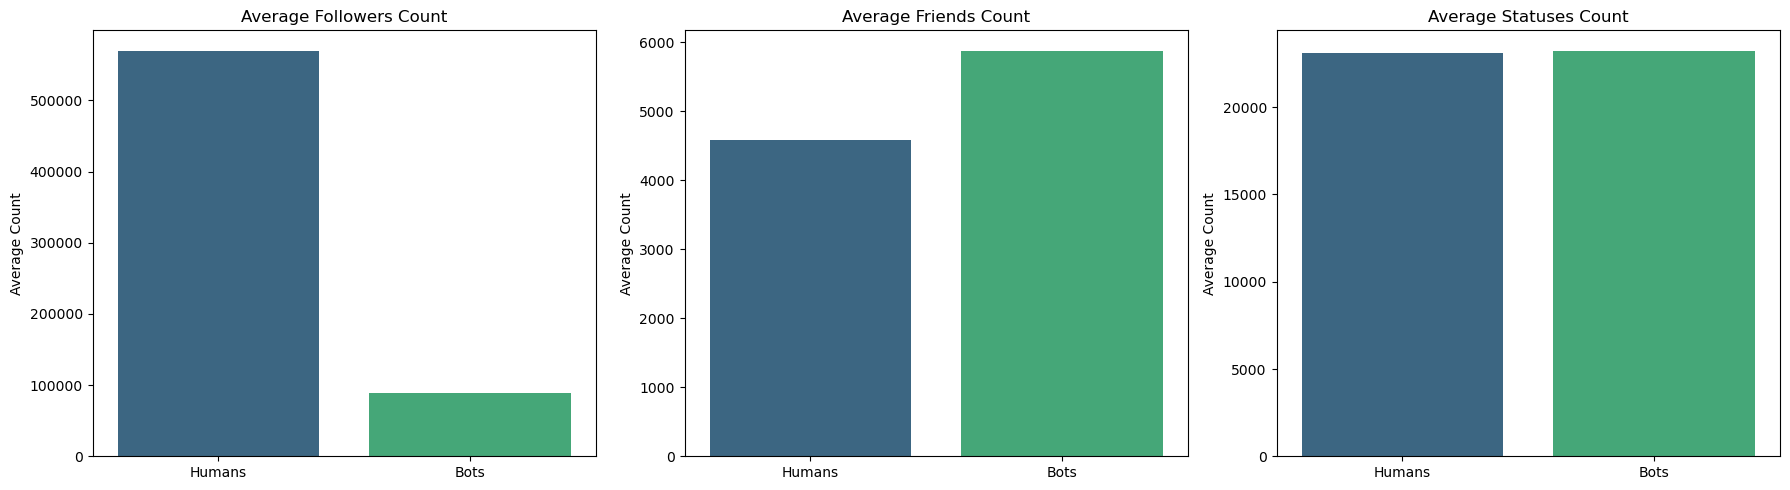

In [233]:
# Data for plotting
types = ['Humans', 'Bots']
palette = "viridis"

# Feature-specific counts (example features: followers_count, friends_count, statuses_count)
counts_followers = [df[df['account_type'] == 0]['followers_count'].mean(), 
                    df[df['account_type'] == 1]['followers_count'].mean()]
counts_friends = [df[df['account_type'] == 0]['friends_count'].mean(), 
                  df[df['account_type'] == 1]['friends_count'].mean()]
counts_statuses = [df[df['account_type'] == 0]['statuses_count'].mean(), 
                   df[df['account_type'] == 1]['statuses_count'].mean()]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Followers Count
sns.barplot(x=types, y=counts_followers, palette=palette, ax=axes[0])
axes[0].set_title("Average Followers Count", fontsize=12)
axes[0].set_ylabel("Average Count", fontsize=10)

# Plot 2: Friends Count
sns.barplot(x=types, y=counts_friends, palette=palette, ax=axes[1])
axes[1].set_title("Average Friends Count", fontsize=12)
axes[1].set_ylabel("Average Count", fontsize=10)

# Plot 3: Statuses Count
sns.barplot(x=types, y=counts_statuses, palette=palette, ax=axes[2])
axes[2].set_title("Average Statuses Count", fontsize=12)
axes[2].set_ylabel("Average Count", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Train Test Split

In [236]:
X = df.drop(columns=['account_type'])
y = df['account_type']

print("Feature columns:")
print(X.columns)
print()
print("Target column:")
print(y.name)

Feature columns:
Index(['default_profile', 'default_profile_image', 'favourites_count',
       'followers_count', 'friends_count', 'geo_enabled', 'lang', 'location',
       'statuses_count', 'verified',
       ...
       'writer', 'writing', 'year', 'years', 'york', 'you', 'young', 'your',
       'youtube', 'في'],
      dtype='object', length=528)

Target column:
account_type


In [238]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using Baseline Models

### Logistic Regression

In [244]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lg = log_reg.predict(X_test_scaled)

# Evaluation
accuracy_lg = accuracy_score(y_test, y_pred_lg)
precision_lg = precision_score(y_test, y_pred_lg)
recall_lg = recall_score(y_test, y_pred_lg)
f1_lg = f1_score(y_test, y_pred_lg)
cm_lg = confusion_matrix(y_test, y_pred_lg)

print("Model: Logistic Regression")
print("---------------------------")
print("Accuracy:", accuracy_lg)
print("Precision:", accuracy_lg)
print("Recall:", accuracy_lg)
print("F1 Score:", accuracy_lg)

Model: Logistic Regression
---------------------------
Accuracy: 0.8296903460837887
Precision: 0.8296903460837887
Recall: 0.8296903460837887
F1 Score: 0.8296903460837887


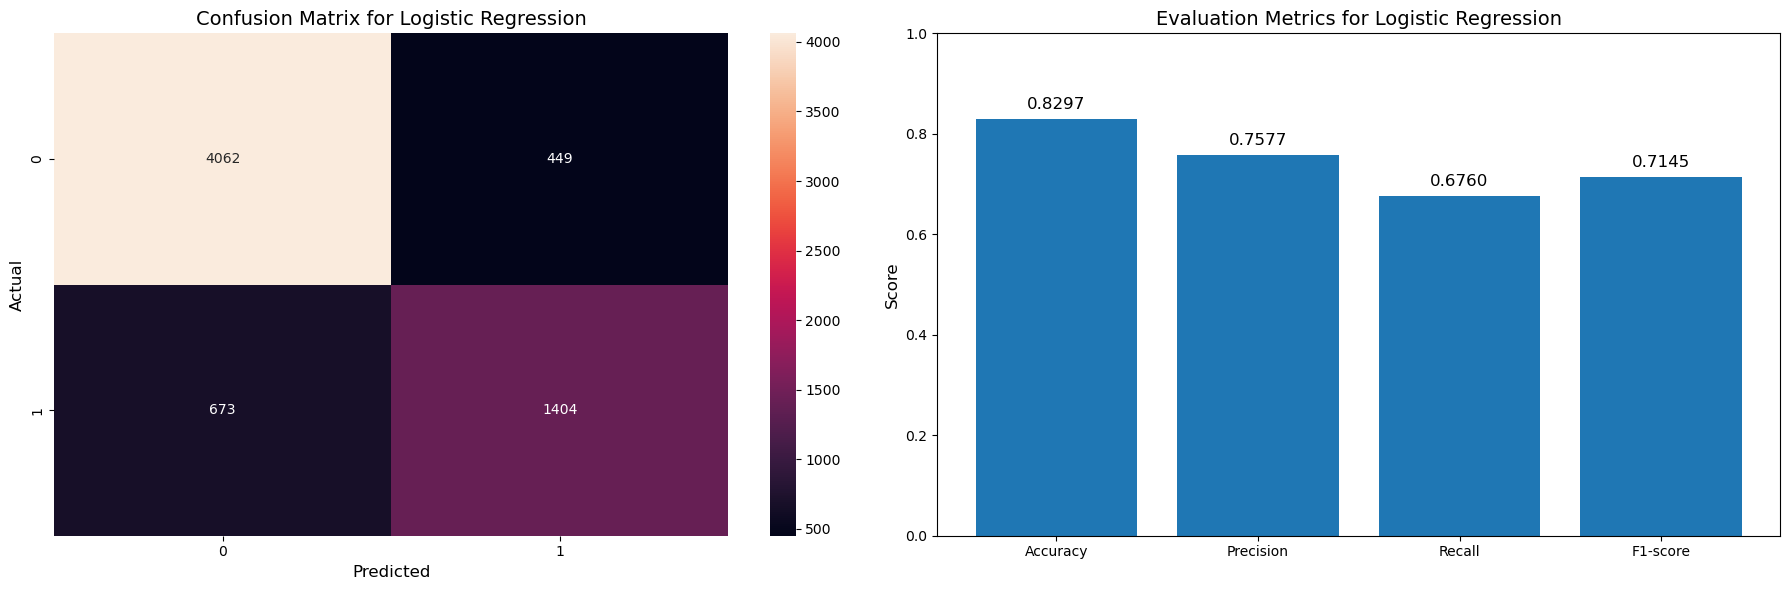

In [245]:
# Data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy_lg, precision_lg, recall_lg, f1_lg]

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
sns.heatmap(cm_lg, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# 2. Bar Chart of Metrics
axes[1].bar(metrics, values)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics for Logistic Regression', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Decision Tree Classifier

In [249]:
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
decision_tree.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = decision_tree.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Model: Decision Tree Model")
print("---------------------------")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)

Model: Decision Tree Model
---------------------------
Accuracy: 0.8195203400121432
Precision: 0.7161635832521909
Recall: 0.7082330284063553
F1 Score: 0.7121762285160977


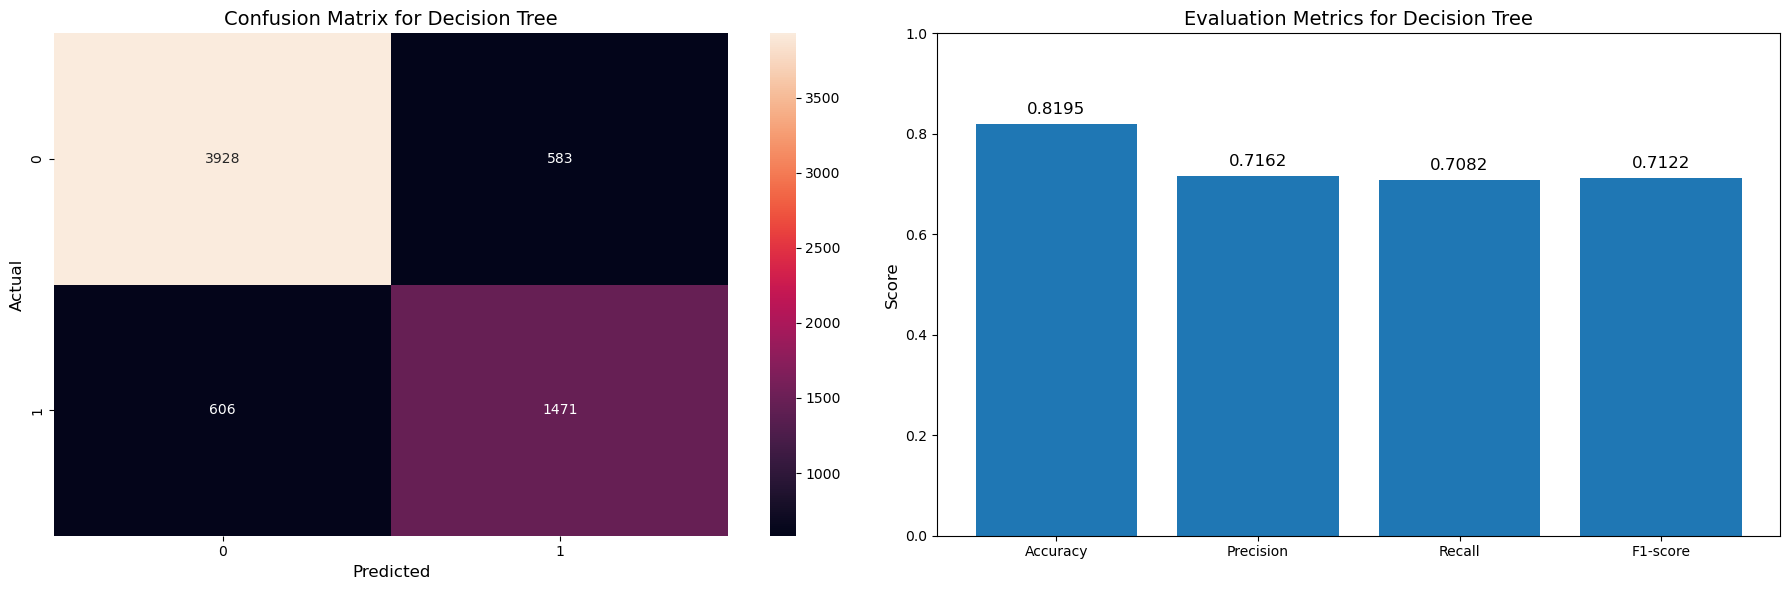

In [250]:
# Data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy_dt, precision_dt, recall_dt, f1_dt]

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix for Decision Tree', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# 2. Bar Chart of Metrics
axes[1].bar(metrics, values)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics for Decision Tree', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Random Forest Classifier

In [252]:
random_forest = RandomForestClassifier(random_state=42)

# Train the Decision Tree model
random_forest.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = random_forest.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Model: Random Forest")
print("---------------------------")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Model: Random Forest
---------------------------
Accuracy: 0.8724954462659381
Precision: 0.8683740321620012
Recall: 0.7019740009629273
F1 Score: 0.7763578274760383


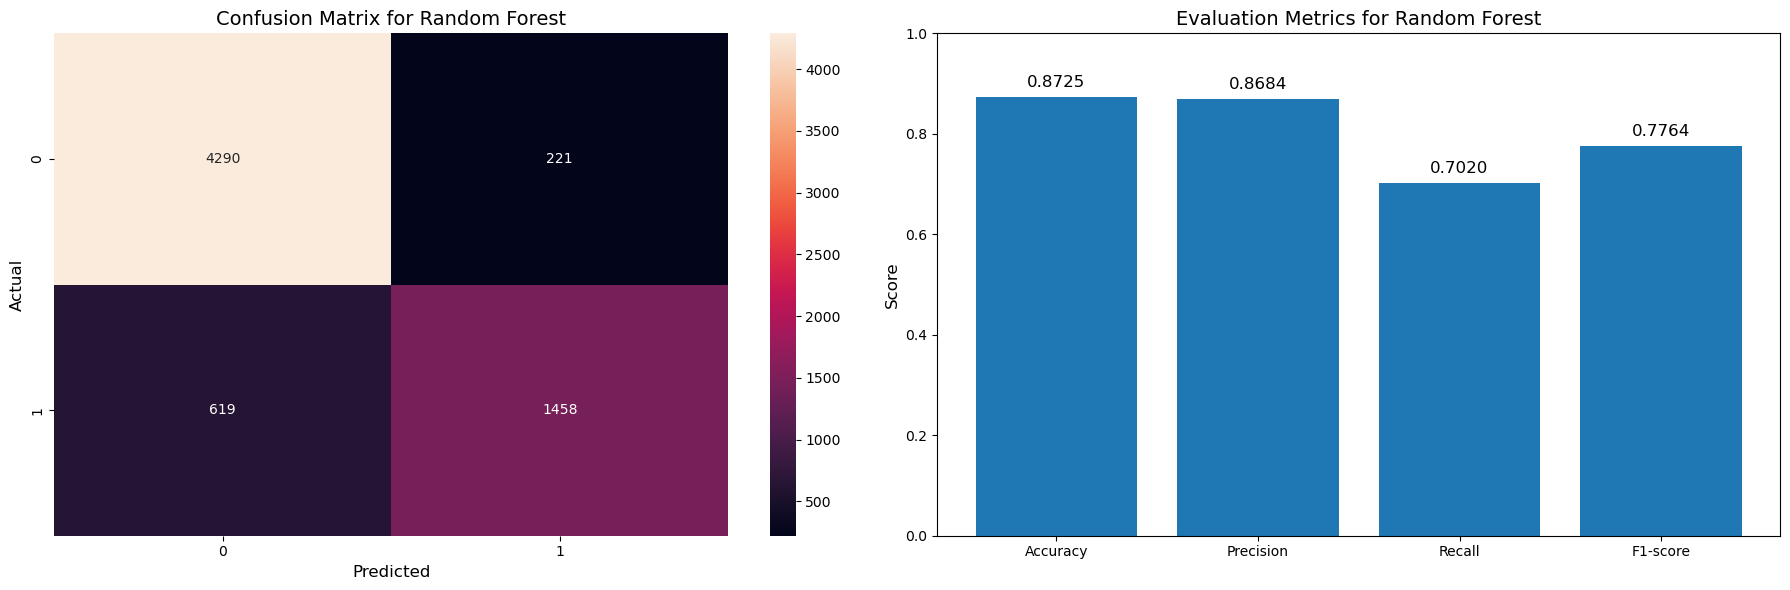

In [253]:
# Data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix for Random Forest', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# 2. Bar Chart of Metrics
axes[1].bar(metrics, values)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics for Random Forest', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Introducing new model

In [282]:
X_catboost = df_catboost.drop(columns=['account_type'])
y_catboost = df_catboost['account_type']

X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(X_catboost, y_catboost, test_size=0.2, random_state=42)

### CatBoost Classifier

In [285]:
catboost_model = CatBoostClassifier(
    iterations=1000,          
    learning_rate=0.1,        
    depth=6,                  
    loss_function='Logloss',  
    boosting_type='Ordered',
    random_state=42,
    verbose=500,
    early_stopping_rounds=100
)

categorical_features = ['lang', 'location']

catboost_model.fit(X_train_catboost, y_train_catboost, cat_features=categorical_features)

y_pred_cb = catboost_model.predict(X_test_catboost)


# Evaluate the model
accuracy_cb = accuracy_score(y_test, y_pred_cb)
precision_cb = precision_score(y_test, y_pred_cb)
recall_cb = recall_score(y_test, y_pred_cb)
f1_cb = f1_score(y_test, y_pred_cb)
cm_cb = confusion_matrix(y_test, y_pred_cb)

print()
print("Model: CatBoost")
print("---------------------------")
print("Accuracy:", accuracy_cb)
print("Precision:", precision_cb)
print("Recall:", recall_cb)
print("F1 Score:", f1_cb)

0:	learn: 0.6301058	total: 68.9ms	remaining: 1m 8s
500:	learn: 0.2287701	total: 26.7s	remaining: 26.6s
999:	learn: 0.2036149	total: 53.4s	remaining: 0us

Model: CatBoost
---------------------------
Accuracy: 0.8731026108075288
Precision: 0.8388858547241944
Recall: 0.7395281656234954
F1 Score: 0.7860798362333674


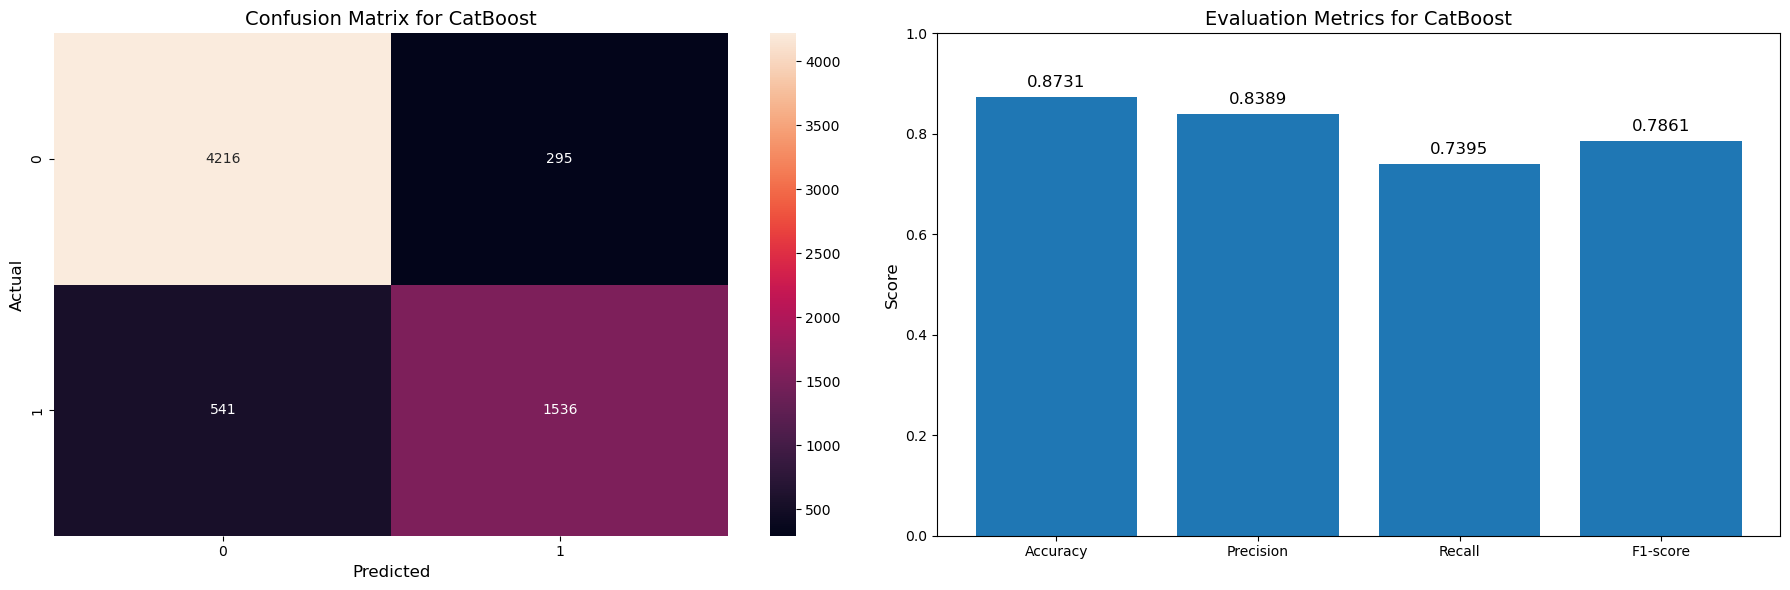

In [287]:
# Data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy_cb, precision_cb, recall_cb, f1_cb]

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
sns.heatmap(cm_cb, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix for CatBoost', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# 2. Bar Chart of Metrics
axes[1].bar(metrics, values)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics for CatBoost', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Comparing Accuracy, F1Score, Precision and Recall

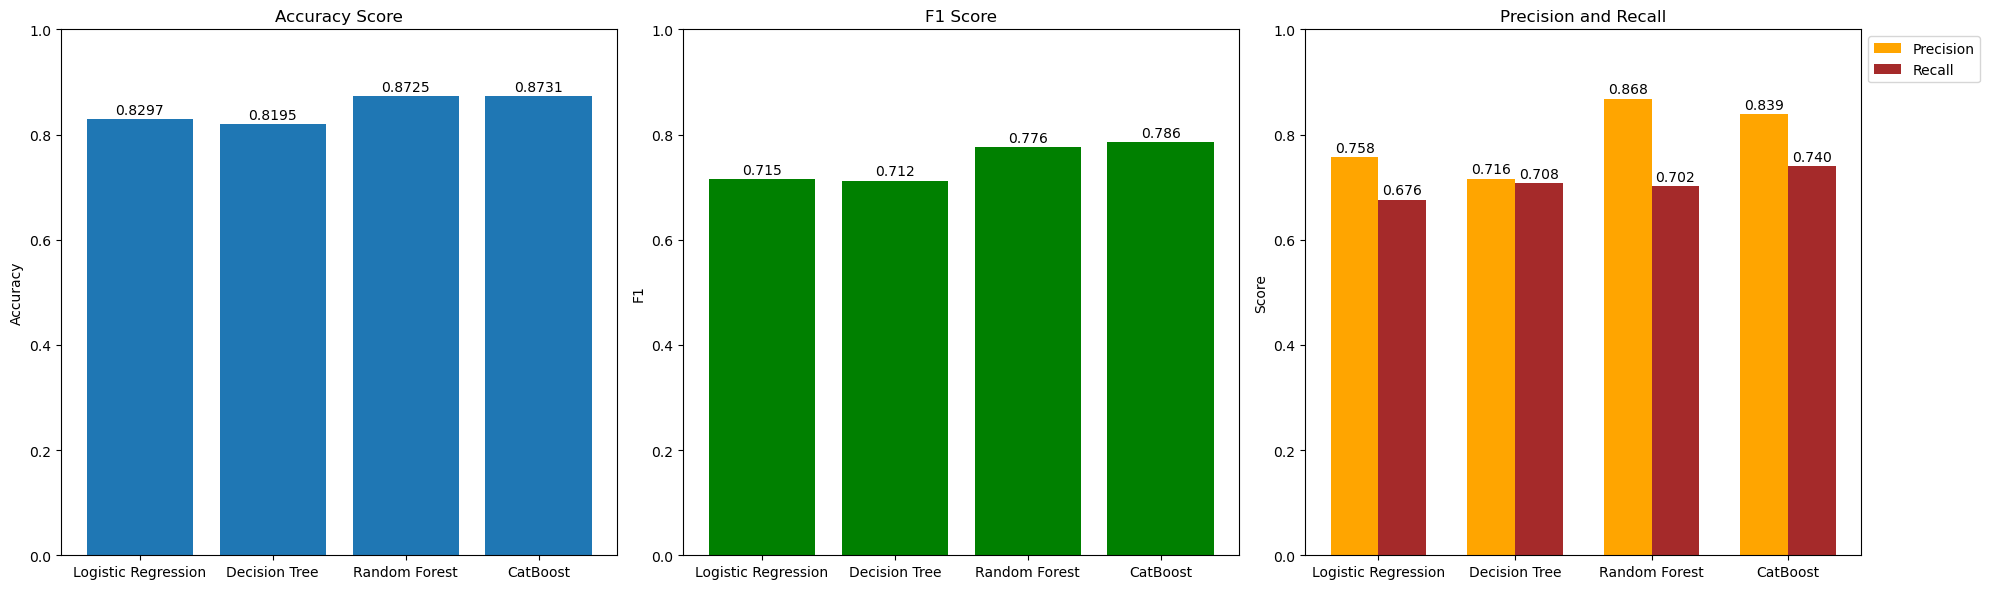

In [292]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for plotting
models_list = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost']
accuracy_list = [accuracy_lg, accuracy_dt, accuracy_rf, accuracy_cb]
f1_score_list = [f1_lg, f1_dt, f1_rf, f1_cb]

# Combine precision and recall for comparison
precision_recall_list = [
    (precision_lg, recall_lg),
    (precision_dt, recall_dt),
    (precision_rf, recall_rf),
    (precision_cb, recall_cb)
]

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy Score
bars_acc = axes[0].bar(models_list, accuracy_list)
axes[0].set_title('Accuracy Score')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)

# Add value labels above bars for accuracy
for bar in bars_acc:
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{bar.get_height():.4f}',
        ha='center',
        fontsize=10
    )

# F1 Score
bars_f1 = axes[1].bar(models_list, f1_score_list, color='green')
axes[1].set_title('F1 Score')
axes[1].set_ylabel('F1')
axes[1].set_ylim(0, 1)

# Add value labels above bars for F1 score
for bar in bars_f1:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{bar.get_height():.3f}',
        ha='center',
        fontsize=10
    )

# Precision and Recall (combined)
bar_width = 0.35
x = np.arange(len(models_list))

# Plot bars for Precision and Recall
for i, (precision, recall) in enumerate(precision_recall_list):
    axes[2].bar(x[i] - bar_width / 2, precision, bar_width, color='orange', label='Precision' if i == 0 else "")
    axes[2].bar(x[i] + bar_width / 2, recall, bar_width, color='brown', label='Recall' if i == 0 else "")

# Add value labels above bars for Precision and Recall
for i, (precision, recall) in enumerate(precision_recall_list):
    axes[2].text(
        x[i] - bar_width / 2,
        precision + 0.01,
        f'{precision:.3f}',
        ha='center',
        fontsize=10
    )
    axes[2].text(
        x[i] + bar_width / 2,
        recall + 0.01,
        f'{recall:.3f}',
        ha='center',
        fontsize=10
    )

# Set x-ticks and labels for the last subplot
axes[2].set_xticks(x)
axes[2].set_xticklabels(models_list)
axes[2].set_title('Precision and Recall')
axes[2].set_ylabel('Score')
axes[2].set_ylim(0, 1)

axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# Finding best model by Tuning

In [295]:
# Base CatBoost model
catboost_model = CatBoostClassifier(
    loss_function='Logloss',
    boosting_type='Ordered',
    random_state=42,
    early_stopping_rounds=100,
    verbose=500
)

param_dist = {
    'iterations': [500, 1000],               
    'learning_rate': [0.03, 0.05],           
    'depth': [4, 6],                         
    'bagging_temperature': [0.25, 0.5],      
    'random_strength': [1, 5],
}

In [297]:
# Use RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=5,                
    scoring='accuracy',      
    cv=2,                    
    random_state=42,
    verbose=1               
)
# Fit the randomized search on the training data
random_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and accuracy
best_params = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Accuracy:", best_accuracy)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
0:	learn: 0.6753511	total: 41.4ms	remaining: 41.4s
500:	learn: 0.2829050	total: 14.9s	remaining: 14.8s
999:	learn: 0.2438417	total: 29.5s	remaining: 0us
0:	learn: 0.6757933	total: 40.9ms	remaining: 40.8s
500:	learn: 0.2677591	total: 14.8s	remaining: 14.7s
999:	learn: 0.2230179	total: 29.4s	remaining: 0us
0:	learn: 0.6638897	total: 40.9ms	remaining: 40.9s
500:	learn: 0.2514149	total: 15.5s	remaining: 15.4s
999:	learn: 0.2194038	total: 30.7s	remaining: 0us
0:	learn: 0.6646113	total: 40.1ms	remaining: 40.1s
500:	learn: 0.2346928	total: 15.2s	remaining: 15.1s
999:	learn: 0.1979531	total: 30s	remaining: 0us
0:	learn: 0.6754505	total: 41ms	remaining: 20.4s
499:	learn: 0.2681075	total: 15.1s	remaining: 0us
0:	learn: 0.6742301	total: 39.5ms	remaining: 19.7s
499:	learn: 0.2526733	total: 15s	remaining: 0us
0:	learn: 0.6754416	total: 18.6ms	remaining: 9.3s
499:	learn: 0.3045367	total: 6.55s	remaining: 0us
0:	learn: 0.6758013	total: 17.1m

In [302]:
optimized_catboost_model = CatBoostClassifier(
    **best_params,           
    loss_function='Logloss',  
    boosting_type='Ordered',
    random_state=42,
    early_stopping_rounds=100,
    verbose=500
)

categorical_features = ['lang', 'location']

optimized_catboost_model.fit(X_train_catboost, y_train_catboost, cat_features=categorical_features)

y_pred_opt_cb = optimized_catboost_model.predict(X_test_catboost)

# Metrics
accuracy_opt_cb = accuracy_score(y_test, y_pred_opt_cb)
precision_opt_cb = precision_score(y_test, y_pred_opt_cb)
recall_opt_cb = recall_score(y_test, y_pred_opt_cb)
f1_opt_cb = f1_score(y_test, y_pred_opt_cb)
cm_opt_cb = confusion_matrix(y_test, y_pred_opt_cb)

print("\nOptimized CatBoost Model with RandomizedSearchCV")
print("---------------------------")
print("Accuracy:", accuracy_opt_cb)
print("Precision:", precision_opt_cb)
print("Recall:", recall_opt_cb)
print("F1 Score:", f1_opt_cb)

0:	learn: 0.6755600	total: 76.7ms	remaining: 1m 16s
500:	learn: 0.2825068	total: 27.2s	remaining: 27.1s
999:	learn: 0.2522376	total: 54.2s	remaining: 0us

Optimized CatBoost Model with RandomizedSearchCV
---------------------------
Accuracy: 0.8734061930783242
Precision: 0.849353569421023
Recall: 0.7274915743861339
F1 Score: 0.7837136929460581


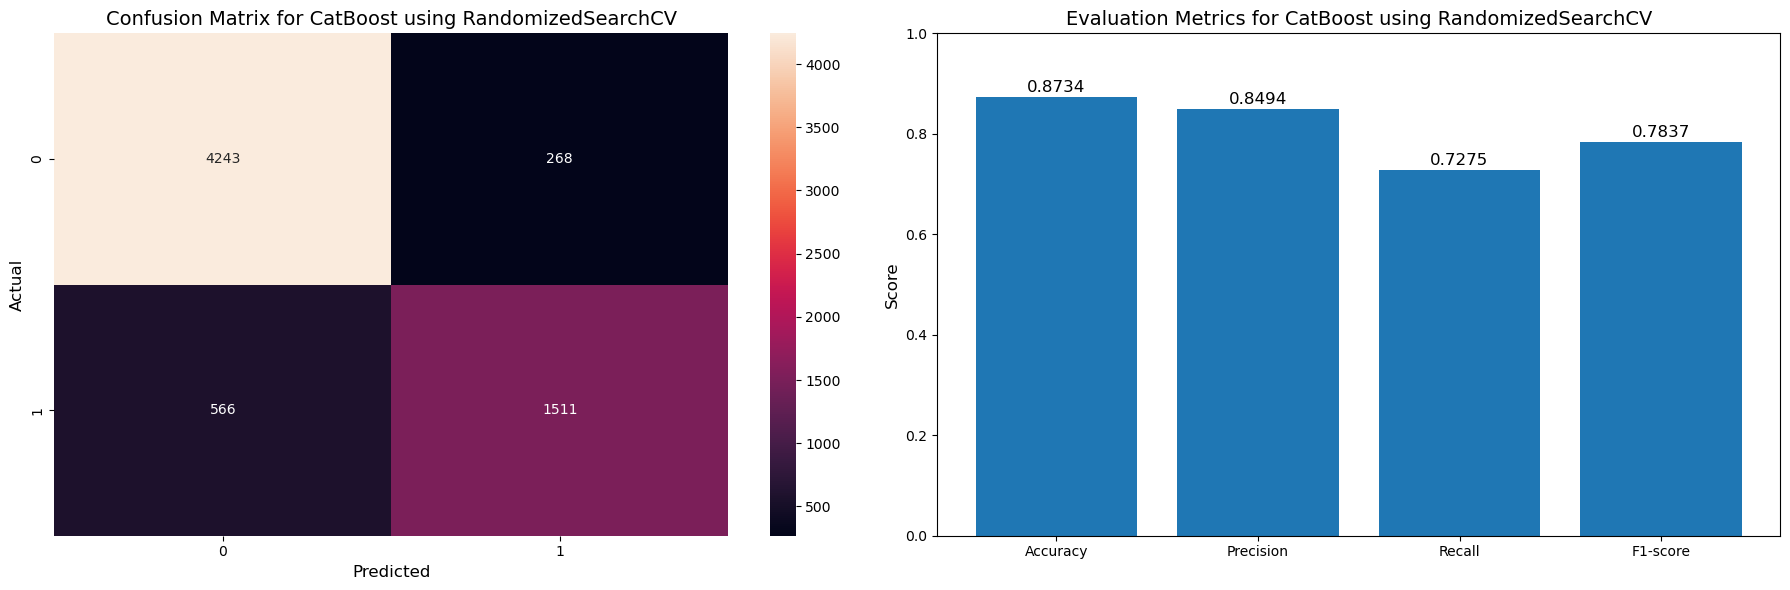

In [308]:
# Data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy_opt_cb, precision_opt_cb, recall_opt_cb, f1_opt_cb]

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
sns.heatmap(cm_opt_cb, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix for CatBoost using RandomizedSearchCV', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# 2. Bar Chart of Metrics
axes[1].bar(metrics, values)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics for CatBoost using RandomizedSearchCV', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

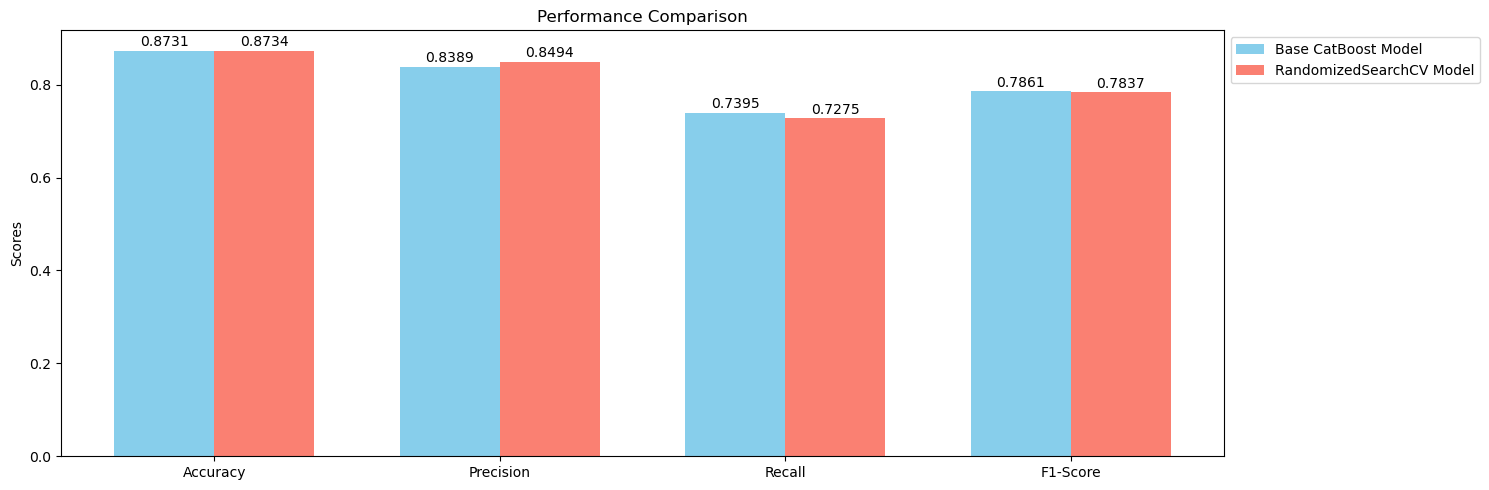

In [312]:
# Metrics for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_1_metrics = [accuracy_cb, precision_cb, recall_cb, f1_cb]
model_2_metrics = [accuracy_opt_cb, precision_opt_cb, recall_opt_cb, f1_opt_cb]

x = np.arange(len(metrics))  
width = 0.35  # Bar width

# Create bar plot
plt.figure(figsize=(15, 5))
bars1 = plt.bar(x - width/2, model_1_metrics, width, label='Base CatBoost Model', color='skyblue')
bars2 = plt.bar(x + width/2, model_2_metrics, width, label='RandomizedSearchCV Model', color='salmon')

# Add labels above the bars
for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.01, 
        f'{bar.get_height():.4f}', 
        ha='center', 
        fontsize=10
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.01, 
        f'{bar.get_height():.4f}', 
        ha='center', 
        fontsize=10
    )

# Labels and legend
plt.ylabel('Scores')
plt.title('Performance Comparison')
plt.xticks(x, metrics)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()